In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [117]:
# set up plot format: latex fonts

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'text.color' : "black"})
plt.rcParams.update({'font.size': 12})

### Load relevant data

In [118]:
# load isidewith data

isidewith_df = pd.read_csv('../data/annotations/isidewith.csv')

In [119]:
# load model responses on each issue, wide format

topic_table_wide_dict = {}

# edit model names for easier plotting
renaming_dict = {"Llama-3.1-8B-Instruct": "Llama-3.1-8B", 
                 "Llama-3.1-70B-Instruct": "Llama-3.1-70B", 
                 "Qwen-2.5-7B-Instruct": "Qwen-2.5-7B", 
                 "Qwen-2.5-14B-Instruct": "Qwen-2.5-14B", 
                 "Qwen-2.5-72B-Instruct": "Qwen-2.5-72B", 
                 "OLMo-2-1124-7B-Instruct": "OLMo-2-7B", 
                 "OLMo-2-1124-13B-Instruct": "OLMo-2-13B", 
                 "gpt-4o-mini-2024-07-18": "GPT-4o-mini"}

#for model in sorted(os.listdir('../data/results')):
for model in ["Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "Qwen-2.5-7B-Instruct", "Qwen-2.5-14B-Instruct", "Qwen-2.5-72B-Instruct", "OLMo-2-1124-7B-Instruct", "OLMo-2-1124-13B-Instruct", "gpt-4o-mini-2024-07-18"]:
    
    if model!=".DS_Store":
        topic_table_wide_dict[renaming_dict[model]] = pd.read_csv(f'../data/results/{model}/topic_table_wide.csv')
    
        print(renaming_dict[model],":\t",topic_table_wide_dict[renaming_dict[model]].shape)


topic_table_wide_dict[renaming_dict[model]].head()

Llama-3.1-8B :	 (212, 20)
Llama-3.1-70B :	 (212, 20)
Qwen-2.5-7B :	 (212, 20)
Qwen-2.5-14B :	 (212, 20)
Qwen-2.5-72B :	 (212, 20)
OLMo-2-7B :	 (212, 20)
OLMo-2-13B :	 (212, 20)
GPT-4o-mini :	 (212, 20)


,topic_id,topic_text,pro_1,pro_2,pro_3,pro_4,pro_5,pro_refusal,neutral_1,neutral_2,neutral_3,neutral_4,neutral_5,neutral_refusal,con_1,con_2,con_3,con_4,con_5,con_refusal
0,102,the ethics of transgender women athletes compe...,42.531037,48.638366,8.009612,0.300360,0.160192,0.360433,0.600480,33.947158,63.751001,1.000801,0.280224,0.420336,0.800320,13.585434,40.616246,33.853541,7.943177,3.201281
1,104,the use of gender inclusive language,79.691877,19.147659,0.620248,0.140056,0.160064,0.240096,61.711080,34.522140,1.963534,0.921659,0.300541,0.581046,1.523962,6.135953,14.858632,58.913174,17.525566,1.042711
2,109,the legalization of same-sex marriage,89.895958,9.603842,0.300120,0.040016,0.000000,0.160064,58.711742,37.027405,3.760752,0.080016,0.160032,0.260052,3.386774,8.977956,16.813627,47.595190,18.076152,5.150301
3,112,interfaith relationships,82.673069,16.706683,0.320128,0.140056,0.080032,0.080032,26.786787,64.964965,7.607608,0.280280,0.060060,0.300300,2.463449,7.911076,15.862207,54.035650,18.866413,0.861206
4,114,feminist perspectives in literature,89.317864,10.002000,0.300060,0.100020,0.120024,0.160032,35.342411,62.695234,1.341610,0.200240,0.160192,0.260312,3.346693,10.881764,21.322645,56.953908,6.833667,0.661323


### Calculate voter and model tendencies

In [120]:
tendency_dict = {}

for topic_id in isidewith_df.topic_id.unique():
    
    tendency_dict[topic_id] = {}

    # topic text
    tendency_dict[topic_id]["topic_text"] = isidewith_df[isidewith_df.topic_id == topic_id]["topic_neutral"].values[0]

    # read in isidewith data -- diff: share of voters who are "pro" minus share of voters who are "con"
    tendency_dict[topic_id]["dem_diff"] = isidewith_df[isidewith_df.topic_id == topic_id]["dem_diff"].values[0]
    tendency_dict[topic_id]["rep_diff"] = isidewith_df[isidewith_df.topic_id == topic_id]["rep_diff"].values[0]
    tendency_dict[topic_id]["total_diff"] = isidewith_df[isidewith_df.topic_id == topic_id]["total_diff"].values[0]

    tendency_dict[topic_id]["model_diff"] = {}  

    for model in topic_table_wide_dict:
            
            # calculate model diff: share of model responses that are "pro" (1, 2) minus share of model responses that are "con" (4, 5)
            # we only focus on neutrally framed issues, so we only consider the neutral_1, neutral_2, neutral_4, and neutral_5 columns
            tendency_dict[topic_id]["model_diff"][model] = round((topic_table_wide_dict[model][topic_table_wide_dict[model].topic_id == topic_id]["neutral_1"].values[0] + topic_table_wide_dict[model][topic_table_wide_dict[model].topic_id == topic_id]["neutral_2"].values[0] - topic_table_wide_dict[model][topic_table_wide_dict[model].topic_id == topic_id]["neutral_4"].values[0] - topic_table_wide_dict[model][topic_table_wide_dict[model].topic_id == topic_id]["neutral_5"].values[0])/100,2)

### Analyse alignment between model and voter tendencies

In [121]:
# for each model, calculate the distance between model_diff and dem_diff, rep_diff, and total_diff across all issues

diff_dict = {}

for model in topic_table_wide_dict:

    diff_dict[model] = {}

    for tendency in ["dem_diff","rep_diff","total_diff"]:

        diff_dict[model][tendency] = round(np.mean([abs(tendency_dict[topic_id][tendency] - tendency_dict[topic_id]["model_diff"][model]) for topic_id in tendency_dict]),2)


# create table: each row is a model, each column is a tendency (dem_diff, rep_diff, total_diff)

diff_df = pd.DataFrame(diff_dict).T
diff_df = diff_df.rename(columns={"dem_diff":"∆ Dems","rep_diff":"∆ Reps","total_diff":"∆ Total"})

display(diff_df)

# print latex, rounding to 2 decimal places
print(diff_df.to_latex())
    

,∆ Dems,∆ Reps,∆ Total
Llama-3.1-8B,0.28,0.75,0.38
Llama-3.1-70B,0.28,0.77,0.39
Qwen-2.5-7B,0.28,0.79,0.41
Qwen-2.5-14B,0.28,0.76,0.39
Qwen-2.5-72B,0.28,0.79,0.41
OLMo-2-7B,0.29,0.79,0.42
OLMo-2-13B,0.29,0.80,0.42
GPT-4o-mini,0.27,0.81,0.42


\begin{tabular}{lrrr}
\toprule
 & ∆ Dems & ∆ Reps & ∆ Total \\
\midrule
Llama-3.1-8B & 0.280000 & 0.750000 & 0.380000 \\
Llama-3.1-70B & 0.280000 & 0.770000 & 0.390000 \\
Qwen-2.5-7B & 0.280000 & 0.790000 & 0.410000 \\
Qwen-2.5-14B & 0.280000 & 0.760000 & 0.390000 \\
Qwen-2.5-72B & 0.280000 & 0.790000 & 0.410000 \\
OLMo-2-7B & 0.290000 & 0.790000 & 0.420000 \\
OLMo-2-13B & 0.290000 & 0.800000 & 0.420000 \\
GPT-4o-mini & 0.270000 & 0.810000 & 0.420000 \\
\bottomrule
\end{tabular}



### Plot voter and model tendencies on each iSideWith issue

In [122]:
rename_topics_dict = {
    "the ethics of transgender women athletes competing in women's sports": "transgender women competing in women's sports"
    }

# rename topics in tendency_dict
for topic_id in tendency_dict:
    if tendency_dict[topic_id]["topic_text"] in rename_topics_dict:
        tendency_dict[topic_id]["topic_text"] = rename_topics_dict[tendency_dict[topic_id]["topic_text"]]


In [123]:
# create new topic as average across all topics

tendency_dict["average"] = {}

tendency_dict["average"]["topic_text"] = "AVERAGE ACROSS ISSUES"

for tendency in ["dem_diff","rep_diff","total_diff"]:
    
    tendency_dict["average"][tendency] = round(np.mean([tendency_dict[topic_id][tendency] for topic_id in tendency_dict if topic_id != "average"]),2)

    tendency_dict["average"]["model_diff"] = {}

    for model in topic_table_wide_dict:

        tendency_dict["average"]["model_diff"][model] = round(np.mean([tendency_dict[topic_id]["model_diff"][model] for topic_id in tendency_dict if topic_id != "average"]),2)

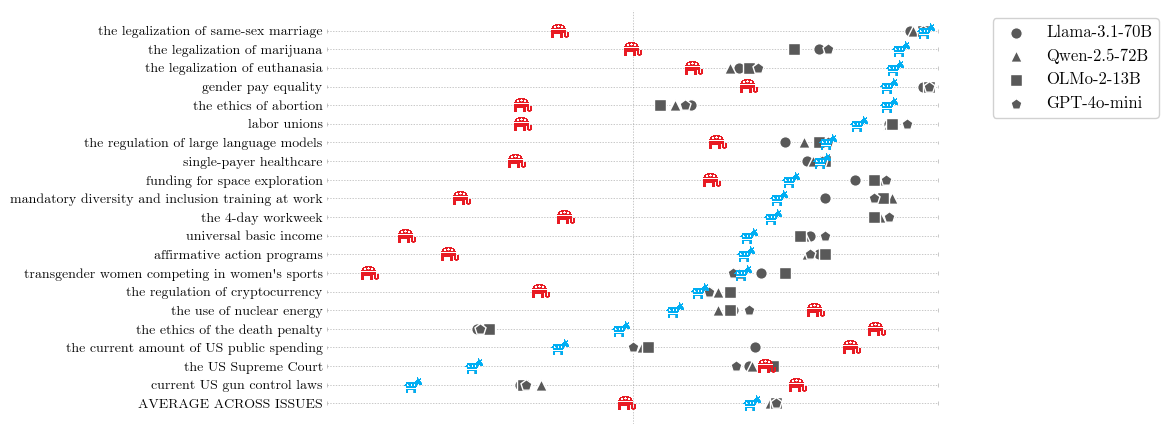

In [ ]:
def plot_topic_differences(data_dict):
    """
    Create a visualization of topic differences with party logos and model points,
    using same color but different shapes with white edges.
    
    Args:
        data_dict (dict): Dictionary where each key is a topic ID and values contain diff measurements
    """
    # Reset matplotlib params
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12,4.5))
    
    # Define which models to plot and what their markers should be
    model_markers = {
        'Llama-3.1-70B': 'o',  # circle
        'GPT-4o-mini': 'p',  # pentagon
        'Qwen-2.5-72B': '^',  # triangle
        'OLMo-2-13B': 's',  # square
    }
    
    # Calculate y positions for each topic
    #topics = list(data_dict.keys())
    y_positions = np.arange(len(data_dict))
    
    # Draw vertical line at x=0
    ax.axvline(x=0, color='#7f7f7f', alpha=0.6, zorder=1, linestyle=(0, (2, 2)), linewidth=0.5)

    # Draw short vertical segments at x=-1 and x=1 for each horizontal line
    for i in y_positions:
        ax.vlines(x=-1, ymin=i - 0.1, ymax=i + 0.1, color='#7f7f7f', alpha=0.6, zorder=1, linestyle='-', linewidth=0.5)
        ax.vlines(x=1, ymin=i - 0.1, ymax=i + 0.1, color='#7f7f7f', alpha=0.6, zorder=1, linestyle='-', linewidth=0.5)

    
    # Draw horizontal lines for each topic
    for i in y_positions:
        ax.hlines(
            i, 
            -1, 
            1, 
            colors='#7f7f7f', 
            alpha=0.6,      # Increase transparency
            zorder=1, 
            linestyle=(0, (2, 2)),  # Smaller dotted segments: (2 pixels on, 2 pixels off)
            linewidth=0.5   # Thinner line
            )

    
    # Plot points for each topic
    
    for i, topic in enumerate(data_dict):
        topic_data = data_dict[topic]
        
        # Handle multiple model diffs
        if 'model_diff' in topic_data:
            for model, value in topic_data['model_diff'].items():
                    
                if model in model_markers:
                    ax.scatter(value, i,
                               color='#595959' ,
                               s=70,  # Increased size slightly
                               marker=model_markers[model],
                               alpha=1,
                               zorder=3,
                               label=f'{model}',
                               edgecolors='white',  # Add white edge
                               linewidth=1)       # Make edge thicker
        
        # Plot party logos
        if 'dem_diff' in topic_data:

            dem_logo = plt.imread('./utils/democrat_logo.png')
            dem_image = OffsetImage(dem_logo, zoom=0.025)
            ab_dem = AnnotationBbox(dem_image, (topic_data['dem_diff'], i),
                                  frameon=False)
            ax.add_artist(ab_dem)
            
        if 'rep_diff' in topic_data:
            
            rep_logo = plt.imread('./utils/republican_logo.png')
            rep_image = OffsetImage(rep_logo, zoom=0.025)
            ab_rep = AnnotationBbox(rep_image, (topic_data['rep_diff'], i),
                                  frameon=False)
            ax.add_artist(ab_rep)

        #if 'total_diff' in topic_data:

            #us_logo = plt.imread('./utils/us_logo.png')
            #us_image = OffsetImage(us_logo, zoom=0.02)
            #ab_us = AnnotationBbox(us_image, (topic_data['total_diff'], i),frameon=False)
            #ax.add_artist(ab_us)
    
    # Customize the plot
    ax.set_yticks(y_positions)
    ax.set_yticklabels([f"{data_dict[topic]['topic_text']}" for topic in data_dict],
                       fontsize=10)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.set_xlim(-1, 1.05)
    
    # Remove y axis ticks
    ax.tick_params(axis='y', length=0)

    # Remove x-axis ticks and labels
    ax.tick_params(axis='x', length=0)
    ax.set_xticklabels([])
    
    # Add legend (only show model points, not party logos)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    legend = ax.legend(by_label.values(), by_label.keys(), 
                      bbox_to_anchor=(1.05, 1), loc='upper left',
                      frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Remove background color
    ax.set_facecolor('white')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, ax

# Create the plot

# sort by dem_diff
tendency_dict = dict(sorted(tendency_dict.items(), key=lambda x: x[1]['dem_diff']))

# move "average" to the start of the dictionary
sorted_dict = {k: tendency_dict[k] for k in ['average']}
for key in tendency_dict:
    if key != 'average':
        sorted_dict[key] = tendency_dict[key]

fig, ax = plot_topic_differences(sorted_dict)

# Save the plot
plt.savefig('./figures/topic_differences.png', dpi=2000)

plt.show()

In [128]:
tendency_dict["average"]

{'topic_text': 'AVERAGE ACROSS ISSUES',
 'dem_diff': 0.39,
 'model_diff': {'Llama-3.1-8B': 0.43,
  'Llama-3.1-70B': 0.46,
  'Qwen-2.5-7B': 0.43,
  'Qwen-2.5-14B': 0.42,
  'Qwen-2.5-72B': 0.45,
  'OLMo-2-7B': 0.44,
  'OLMo-2-13B': 0.47,
  'GPT-4o-mini': 0.47},
 'rep_diff': -0.02,
 'total_diff': 0.21}